# INSTAL

In [189]:
# pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [190]:
# pip install lazypredict --user

In [191]:
# !pip install catboost
# !pip install -U scikit-learn

# LIBRARY

In [192]:
import numpy as np # linear algebra
import pandas as pd
import sys
# import sklearn

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone


from sklearn.decomposition import PCA

import xgboost as xgb

from datetime import timedelta, datetime, date

import lazypredict
from lazypredict.Supervised import LazyRegressor
from catboost import CatBoostRegressor

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import accuracy_score
from tqdm import tqdm
# from tqdm import tnrange

# SETUP

In [193]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

VERSION    = 16
VAL_SIZE   = 0.20   # 20%
RANDOM_SEED = 42

x_size = 8
y_size = 5

In [194]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
# print('scikit-learn :', sklearn.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


# FUNCTIONS

In [195]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [196]:
def getCountPlot(df, feature, x_s=x_size, y_s=y_size):
    plt.figure(figsize=(x_s, y_s))
    sns.countplot(data=df,
            order = df[feature].value_counts().index, 
            y=feature)
    plt.title(f'Распределение значений признака {feature}')
    plt.show;

In [197]:
def interquartile_range(series, x_s=x_size, y_s=y_size, bins=50):
    '''
    Вычисляет межквартильный размах в серии
    series - Pandas Series
    x_s (int) - размер оси x
    y_s (int) - размер оси y
    bins (int) - количество столбцов гистограммы
    '''
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25, perc75 = series.quantile(0.25), series.quantile(0.75)
    f, l = perc25 - 1.5*IQR, perc75 + 1.5*IQR

    title = f'25-й перцентиль: {perc25}, \
    75-й перцентиль: {perc75},\nIQR: {IQR}, границы выбросов: [{f}, {l}]'

    plt.figure(figsize=(x_s, y_s))
    sns.histplot(data=series.loc[series.between(perc25 - 1.5*IQR,
                                                perc75 + 1.5*IQR)], bins=bins)
    plt.title(f'IQR\n{title}');

In [198]:
def emission_replacement(df, column, method='median'):
    '''
    Заменяет выбросы в серии вычисленным значением 
    method='median' - замена на медиану
    method='average' - замена на среднее
    method ='probable' - вероятностное распределение
    '''
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR

    if method =='median':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].median()
    elif method =='average':
        df.loc[(df[column] < f) | (df[column] > l), column] = df[column].mean()
    elif method =='probable':
        # замена выбросов на nan 
        df[column] = np.where((df[column] < f) | (df[column] > l), np.nan, df[column])
        mask = df[column].isna()
        # статистика распределения значений
        p = df[column].value_counts() / len(df[column].dropna())
        # заполняем пропуски с вероятностью `p`
        df.loc[mask, column] = np.random.choice(p.index.to_list(),
                                            size=mask.sum(), 
                                            p=p.to_list())

In [199]:
def getBalansedFrame(test,train,feature):
    '''
    Функция удаляет из датафрейма train значения тех признаков (из списка feature),
    которых нет во фрейме test. Тем самым оставляем для обучения только значимые данные.
    feature - список признаков, по которым будем балансировать фрейм train
    '''
    new_df = train.copy()
    for col in feature:
        test_uniq = test[col].unique()
        new_df = new_df[new_df[col].isin(test_uniq)]
    return (new_df)

# DATA

In [200]:
train = pd.read_csv('parsing_auto_ru.csv', sep='\t', low_memory = False)  # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [201]:
display(f'train {train.shape}, test {test.shape}, sample_submission {sample_submission.shape}')

'train (113327, 33), test (34686, 32), sample_submission (34686, 2)'

# INSPECTION

Ошибки, выявленные при сборе данных

## Целевая переменная - price

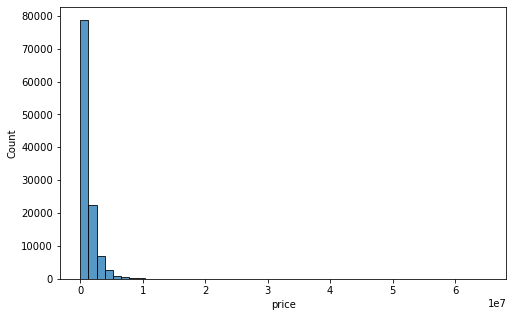

In [202]:
plt.figure(figsize=(8, 5))
sns.histplot(data=train['price'], bins=50);

Видно, что есть небольшое количество очень низких цен. В результате выборочной проверки нескольких ссылок выяснилось, что это ошибка при сборе данных - эти автомобили уже были проданы. Можно удалить эти экстремальные данные 

In [203]:
train.price.value_counts().sort_index()

0.50           373
0.85           104
1.00            25
3999.00         74
12000.00         1
              ... 
29000000.00      1
29800000.00      1
30850000.00      1
62500000.00      1
65000000.00      1
Name: price, Length: 7419, dtype: int64

* Цены меньше 3999 - явная ошибка при сборе данных
* Цена 3999 - 74 автомобиля по такой цене - тоже ошибка (выборочная проверка показала, что автомобили уже проданы)
* за 12 тысяч продаётся реальный [автомобиль](https://auto.ru/cars/used/sale/nissan/bluebird/1104156088-92a6cd31/)

Т.о. удаляем строки с ценами меньше 12000

In [204]:
train = train.query("price >= 12000").reset_index(drop=True)

## Первичный осмотр

In [205]:
# осмотрим тестовые и тренеровочные данные:
for i in [train, test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112751 entries, 0 to 112750
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              112751 non-null  object 
 1   brand                 112751 non-null  object 
 2   car_url               112751 non-null  object 
 3   color                 112751 non-null  object 
 4   complectation_dict    16972 non-null   object 
 5   description           112724 non-null  object 
 6   engineDisplacement    112751 non-null  object 
 7   enginePower           112751 non-null  object 
 8   equipment_dict        73347 non-null   object 
 9   fuelType              112751 non-null  object 
 10  image                 108758 non-null  object 
 11  mileage               112751 non-null  int64  
 12  modelDate             112751 non-null  int64  
 13  model_info            112751 non-null  object 
 14  model_name            112751 non-null  object 
 15  

# Балансировка датасетов

сделаем так, чтобы в train не было таких значений, которых нет и в test

Попытаемся сбалансировать значения признаков в train и test 

P.S. Этот шаг добавлен уже после первых экспериментов и получения результата на Kaggle. 
Несмотря на то, что эта балансировка улучшила качество метрики на 0.5-0.7 на разных моделях 
это не дало улучшения результата на Kaggle.

In [206]:
# сбалансируем датасет train
column = ['bodyType','brand','color','engineDisplacement','enginePower','modelDate','model_name','name',
         'numberOfDoors','productionDate','vehicleConfiguration','vendor','ПТС']

new_train = getBalansedFrame(test,train,column)
train=new_train.copy()

In [207]:
# отметим тренировочный и тестовый
train['sample'] = 1
test['sample'] = 0
# соединим их вместе
data = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [208]:
# осмотрим рабочие данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140463 entries, 0 to 140462
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              140463 non-null  object 
 1   brand                 140463 non-null  object 
 2   car_url               140463 non-null  object 
 3   color                 140463 non-null  object 
 4   complectation_dict    22754 non-null   object 
 5   description           140436 non-null  object 
 6   engineDisplacement    140463 non-null  object 
 7   enginePower           140463 non-null  object 
 8   equipment_dict        94081 non-null   object 
 9   fuelType              140463 non-null  object 
 10  image                 136682 non-null  object 
 11  mileage               140463 non-null  int64  
 12  modelDate             140463 non-null  int64  
 13  model_info            140463 non-null  object 
 14  model_name            140463 non-null  object 
 15  

## Описание полей


1. bodyType - тип кузова
1. brand - бренд автомобиля
1. car_url - ссылка на объявление, уникальные
1. color - цвет
1. complectation_dict - описание комплектации (словарь)
1. description - описание автомобиля продавцом
1. engineDisplacement - объём двигателя
1. enginePower - мощность двигателя
1. equipment_dict - оснащенность автомобиля опциями
1. fuelType - тип топлива
1. image - фото
1. mileage - пробег
1. modelDate - год начала выпуска этой модели автомобиля 
1. model_info - общая информация об автомобиле (марка, модель, правила склонения в русском языке и т.д)
1. model_name - название модели латиницей
1. name - часть технического описания автомобиля, состоит из объёма двигателя, типа КПП и мощности двигателя
1. numberOfDoors - количество дверей
1. parsing_unixtime - время парсинга
1. priceCurrency - валюта "RUB" Constant
1. productionDate - год выпуска этого автомобиля
1. sell_id id объявления
1. super_gen - словарь с величинами технических признаков (клиренс, разгон до 100 км/ч, расход топлива и т.д)
1. vehicleConfiguration - Конфигурация автомобиля, составной признак (тип кузова, КПП, мощность двигателя)
1. vehicleTransmission - тип КПП
1. vendor - для какого рынка выпущен автомобиль (Европа, Азия, Америка)
1. Владельцы - количество прошлых владельцев автомобиля
1. Владение - длительность владения автомобилем продавцом
1. ПТС - оригинал/дубликат
1. Привод - тип привода (передний, задний, полный)
1. Руль - левый/правый
1. Состояние - если авто требует ремонта - нет метки, есл не требует - значение "Не требует ремонта"
1. Таможня - "Растаможен"	Constant
1. price - цена 



















## Уникальность строк

В датасете есть как минимум 2 признака, которые должны содержать уникальные значения
* sell_id
* car_url


In [209]:
#  Проверим на уникальность всех id - есть не уникальные
len(data) == data.sell_id.nunique()

False

In [210]:
# удалим дубликаты из train
data.drop_duplicates(subset=['sell_id'], keep='last',inplace=True)

In [211]:
# проверим на nan в sell_id  - отсутствуют
len(data.sell_id) - data.sell_id.count()

0

## Пропуски данных

In [212]:
# проверим на наличие пропусков
print(f'Всего пропущенных данных {data.isna().sum().sum()}')

Всего пропущенных данных 300919


In [213]:
data.isna().sum()

bodyType                     0
brand                        0
car_url                      0
color                        0
complectation_dict      116782
description                 27
engineDisplacement           0
enginePower                  0
equipment_dict           46014
fuelType                     0
image                     3773
mileage                      0
modelDate                    0
model_info                   0
model_name                   0
name                         0
numberOfDoors                0
parsing_unixtime             0
priceCurrency                0
productionDate               0
sell_id                      0
super_gen                    0
vehicleConfiguration         0
vehicleTransmission          0
vendor                       0
Владельцы                    0
Владение                 97049
ПТС                          1
Привод                       0
Руль                         0
Состояние                 2587
Таможня                      0
price   

Очень много пропусков содержат:
* complectation_dict
* equipment_dict

И хотя они очень содержательны (описывают технические характеристики автомобиля в очень широком спектре), от них придётся отказаться.
Возможно стоит (в качестве эксперимента) в дальнейшем сапарсить данные, содержащие equipment_dict, добаввить их в датасет и обработать этот признак (например векторизовать)

* Владение - тоже исключаем

* description - можно удалить всесь признак, так как в значения попали не только описания владельцев, но и общий рекламный текст (ошибка при парсинге)

* image - без фото как правило объявления о битых машинах, удаляем этот признак.

* vendor - можно заполнить пропуски наиболее частым значением

* ПТС - тоже заполнить самым частым

* Состояние - необходимо пропуски заполнить значением "Требует ремонта"

* model_info - дублирует имеющиеся признаки - удалить


In [214]:
# Удалим признаки, содержащие слишком большое число пропусков или те, которые точно не нужны
data.drop(['complectation_dict', 'equipment_dict','image', 'Владение','Таможня',
           'priceCurrency','model_info'], axis=1, inplace=True)


* priceCurrency - валюта везде одна
* Таможня - все значения "Растаможен"


Заполним пропуски в vendor, ПТС и Состояние



In [215]:
# Заменяем самым частым значением
for i in ['vendor','ПТС']:
    top = data[i].describe()['top']
    data[i] = data[i].fillna(top)

# Следуя логике - это бинарный признак
data['Состояние'] = data['Состояние'] .fillna('Требует ремонта')

Удалим оставшиеся пустые значения в description                 

In [216]:
data.dropna(subset=['description'], inplace=True)

Проверим - остались ли пропуски в данных

In [217]:
print(f'Всего пропущенных данных {data.isna().sum().sum()}')

Всего пропущенных данных 34686


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139331 entries, 0 to 140462
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              139331 non-null  object 
 1   brand                 139331 non-null  object 
 2   car_url               139331 non-null  object 
 3   color                 139331 non-null  object 
 4   description           139331 non-null  object 
 5   engineDisplacement    139331 non-null  object 
 6   enginePower           139331 non-null  object 
 7   fuelType              139331 non-null  object 
 8   mileage               139331 non-null  int64  
 9   modelDate             139331 non-null  int64  
 10  model_name            139331 non-null  object 
 11  name                  139331 non-null  object 
 12  numberOfDoors         139331 non-null  int64  
 13  parsing_unixtime      139331 non-null  int64  
 14  productionDate        139331 non-null  int64  
 15  

# NAIVE MODEL

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [219]:
# снова выделим train и test из подготовленных на этом этапе данных
train = data[data['sample'] == 1].copy()
test = data[data['sample'] == 0].copy()

# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType','brand','color','engineDisplacement','enginePower',
            'fuelType','model_name','name','numberOfDoors','productionDate',
            'vehicleConfiguration','vehicleTransmission','Владельцы',
            'Привод','Руль']


df_train = train[columns].copy()
df_test = test[columns].copy()
y = train['price']

### Label Encoding

In [220]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_naiv = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [221]:
df_naiv.sample()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Привод,Руль,sample
115400,внедорожник 5 дв.,TOYOTA,белый,4.6 LTR,309 N12,бензин,LAND_CRUISER,4.6 AT (309 л.с.) 4WD,5,2015,ALLROAD_5_DOORS AUTOMATIC 4.6,автоматическая,1 владелец,полный,Левый,1


In [222]:
for colum in ['bodyType', 'brand', 'color', 'engineDisplacement']:
    df_naiv[colum] = df_naiv[colum].astype('category').cat.codes

In [223]:
X = df_naiv.query('sample == 1').drop(['sample'], axis=1)
X_sub = df_naiv.query('sample == 0').drop(['sample'], axis=1)

### Train Split

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [225]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [226]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 140.51%


# EDA

## PANDAS PROFILING

html доступен по ссылке

[report.html](https://drive.google.com/file/d/1FQpFLa1_nhmWpQqQdFsRrj5RVkcBMUCu/view?usp=sharing)



In [227]:
# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_notebook_iframe() # развёрнутый вид
# profile.to_file("report.html") # в файл

## Категориальные признаки

### bodyType

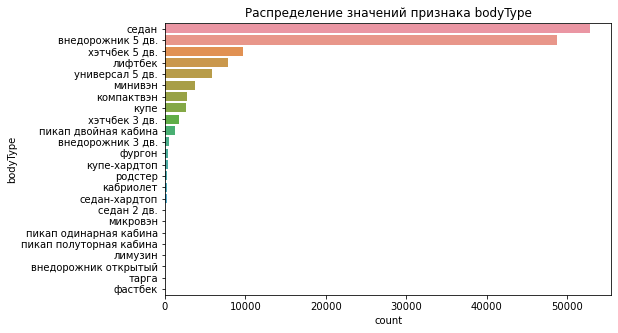

In [228]:
getCountPlot(data,'bodyType')

### brand

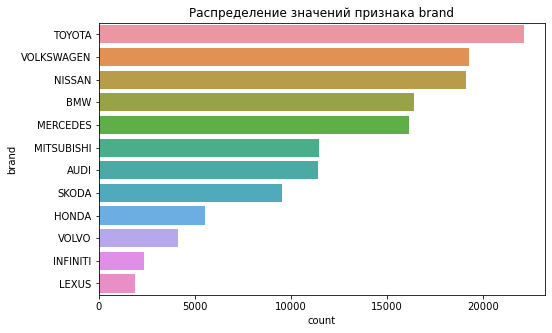

In [229]:
getCountPlot (data,'brand')

###  color

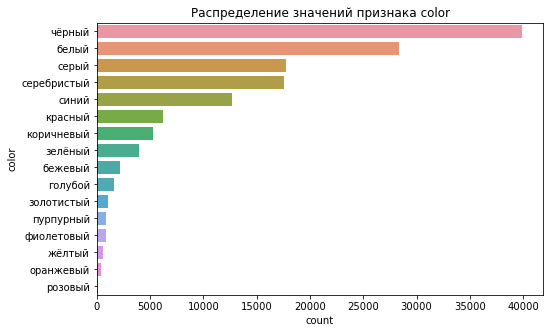

In [230]:
getCountPlot(data,'color')

### description

In [231]:
data.description

0         Продаю свою авоську, автомобиль полностью обсл...
1         Авто в идеальном состоянии, по техническому со...
2         Авто в отличном тех состоянии, установлено ГБО...
3         Продам Volkswagen passat b6 в хорошем состояни...
4         ПТС таможенный, за все время один собственник!...
                                ...                        
140458    Продается BMW 316i в отличном состоянии. Прода...
140459                       Продаётся отличный автомобиль.
140460                                    Хорошее состояние
140461    Автомобиль в идеальном состоянии . Куплен новы...
140462     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 139331, dtype: object

Это описание автомобиля, сделанное владельцем.
Есть как минимум 2 пути - векторизовать признак или простой - создать на его основе признак description_len, содержащий длинну текста (исходим из предположения, что чем подробнее описание, тем большую стоимость продавец хочет выручить, а значит должна быть зависимость).

In [232]:
#  Создадим новый числовой признак
data['description_len'] = data['description'].apply(lambda x: len(str(x)))

In [233]:
# удаляем
data.drop(['description'], axis=1, inplace=True)

In [234]:
# посмотрим на новый признак
data.description_len.describe()

count   139331.00
mean       610.44
std        739.57
min          1.00
25%        150.00
50%        339.00
75%        816.00
max      29938.00
Name: description_len, dtype: float64

Очевидно, что поля с описанием содержали аномальные значения - минимальная длина текста 1, масимальная почти 3 тысячи. Это очевидные ошибки

In [235]:
data.description_len.value_counts().sort_index()

1        129
2         12
3         60
4         93
5         68
        ... 
12911      1
13320      1
17468      1
28789      1
29938      1
Name: description_len, Length: 4243, dtype: int64

За образец возьмем тестовый датафрейм

In [236]:
mn = data[data['sample'] == 0]['description_len'].min()
mx = data[data['sample'] == 0]['description_len'].max()
data = data.query('description_len >= @mn & description_len <= @mx').reset_index(drop=True)

Мы создали этот признак из описания - он должен отражать длинну текста описания.
Возможно текст не везде был адекватный, в таком случае в этом признаке мы увидим аномалии распределения

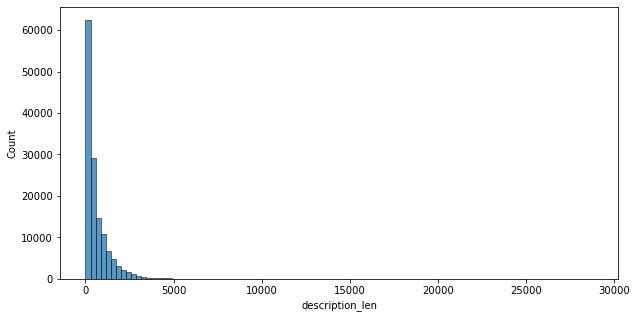

In [237]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['description_len'], bins=100); #, log_scale=True

Видим, что есть выбросы

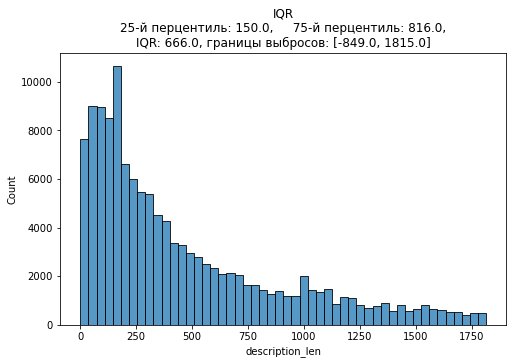

In [238]:
interquartile_range(data['description_len'], bins=50)

In [239]:
# заменим выбросы на медиану
emission_replacement(data,'description_len', method='probable')

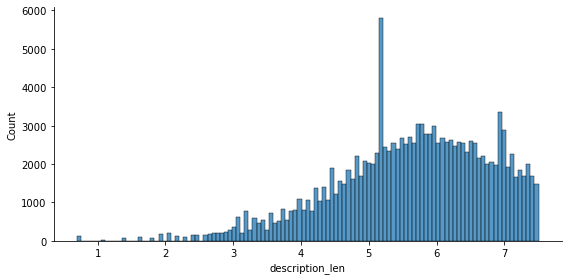

In [240]:
# логарифмируем
data['description_len'] = data['description_len'].apply(lambda w: np.log(w + 1))
sns.displot(data=data, x="description_len", height=4, aspect=2);

### engineDisplacement

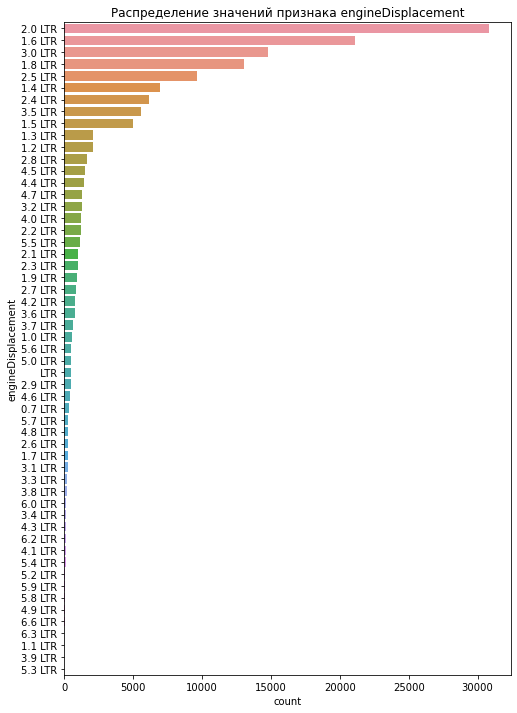

In [241]:
getCountPlot(data,'engineDisplacement',8,12)

Есть значение признака без указания объёма двигателя:

In [242]:
data[data['engineDisplacement']==' LTR'].groupby(['brand',
                                                  'model_name',
                                                  'fuelType'])['sell_id'].count()

brand       model_name  fuelType
AUDI        E_TRON      электро      12
BMW         I3          электро      45
MERCEDES    B_KLASSE    электро       3
MITSUBISHI  I_MIEV      электро       5
NISSAN      LEAF        электро     408
VOLKSWAGEN  GOLF        электро       7
Name: sell_id, dtype: int64

Это электромобили

In [243]:
# очистим признак от ненужных букв и заменим пустые значения в электрокарах на 0

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 0 if x==' LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].astype(str).apply(lambda x: x.split()[0])
data['engineDisplacement'] = data['engineDisplacement'].astype(float)

### enginePower

In [244]:
data['enginePower'].unique()

array(['290 N12', '173 N12', '309 N12', '150 N12', '133 N12', '174 N12',
       '200 N12', '144 N12', '148 N12', '249 N12', '241 N12', '235 N12',
       '181 N12', '282 N12', '140 N12', '277 N12', '91 N12', '273 N12',
       '146 N12', '80 N12', '102 N12', '280 N12', '224 N12', '450 N12',
       '105 N12', '116 N12', '381 N12', '163 N12', '335 N12', '147 N12',
       '170 N12', '250 N12', '136 N12', '99 N12', '152 N12', '313 N12',
       '124 N12', '178 N12', '132 N12', '310 N12', '255 N12', '110 N12',
       '69 N12', '177 N12', '130 N12', '109 N12', '100 N12', '125 N12',
       '103 N12', '115 N12', '231 N12', '90 N12', '388 N12', '204 N12',
       '122 N12', '340 N12', '145 N12', '500 N12', '510 N12', '612 N12',
       '275 N12', '208 N12', '276 N12', '118 N12', '211 N12', '272 N12',
       '525 N12', '190 N12', '296 N12', '517 N12', '95 N12', '184 N12',
       '143 N12', '179 N12', '64 N12', '380 N12', '182 N12', '75 N12',
       '263 N12', '234 N12', '367 N12', '394 N12', '74 N12'

In [245]:
# очистим
data['enginePower'] = data['enginePower'].str.replace(' N12', '')
data['enginePower'] = data['enginePower'].astype(int)

In [246]:
data['enginePower'].describe()

count   139330.00
mean       177.49
std         84.28
min         30.00
25%        117.00
50%        152.00
75%        215.00
max        639.00
Name: enginePower, dtype: float64

### fuelType

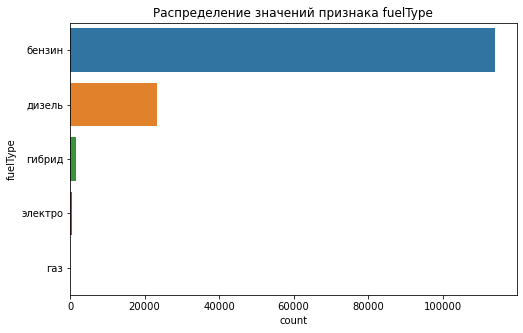

In [247]:
getCountPlot(data,'fuelType')

### modelDate

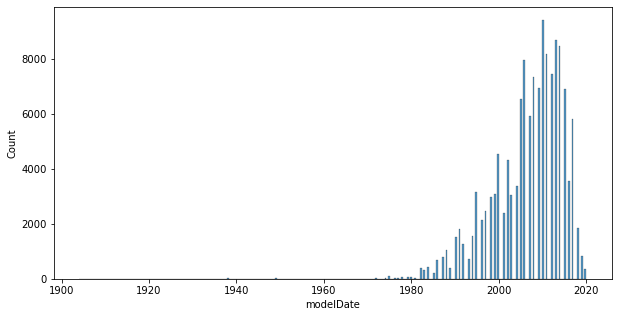

In [248]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="modelDate");

Больше всего в продаже 10-летних моделей

### numberOfDoors

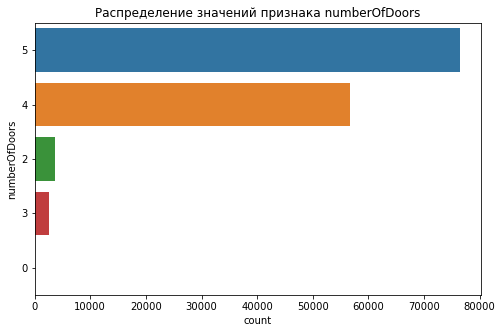

In [249]:
getCountPlot(data,'numberOfDoors')

у одного автомобиля указано 0 дверей

In [250]:
data[data['numberOfDoors'] == 0]

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len
121588,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,5.30,32,бензин,48000,1904,SIMPLEX,...,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,Не требует ремонта,nan,0,6.67


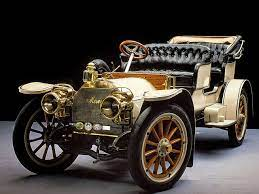

Вот такой, действительно - без окон, без дверей.

### productionDate

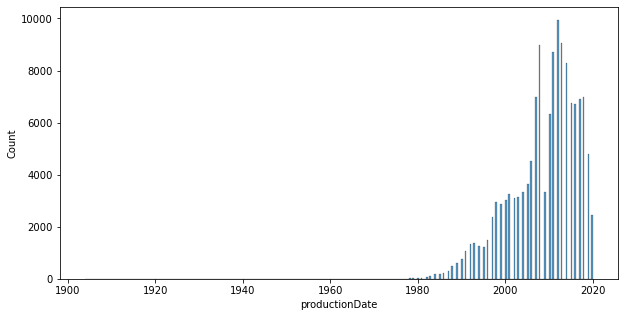

In [251]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="productionDate");

Почти копия modelDate

Вероятно будут сильно коррелировать - под наблюдение

### vehicleTransmission

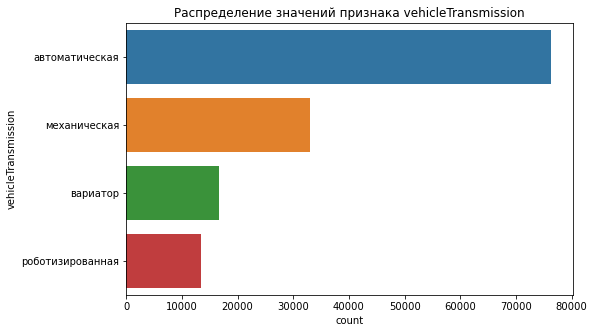

In [252]:
getCountPlot(data,'vehicleTransmission')

### super_gen - удалить

In [253]:
# Очень много уникальных наименований
data['super_gen'].nunique()

14073

In [254]:
# посмотрим на состав
data['super_gen'].value_counts()[:2]

{'id': '6214876', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'MECHANICAL', 'power': 105, 'power_kvt': 77, 'human_name': '1.6 MT (105 л.с.)', 'acceleration': 10.5, 'clearance_min': 170, 'fuel_rate': 6.5}    683
{'id': '20726520', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'AUTOMATIC', 'power': 110, 'power_kvt': 81, 'human_name': '1.6 AT (110 л.с.)', 'acceleration': 11.7, 'clearance_min': 163, 'fuel_rate': 5.9}    665
Name: super_gen, dtype: int64

Строки содержат как минимум 3 интересных количественных признака:

* acceleration
* clearance_min
* fuel_rate

Возможно стоит попробовать их извлечь, пока удалим.

In [255]:
data.drop(['super_gen'], axis=1, inplace=True)

### vendor

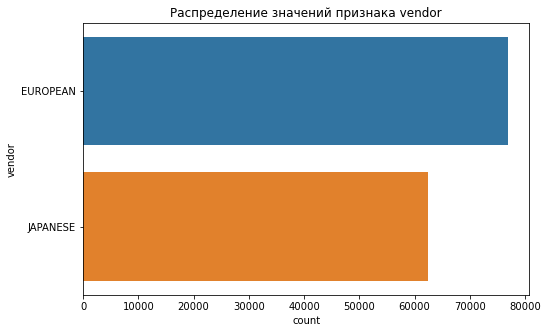

In [256]:
getCountPlot(data,'vendor')

Очень мало автомобилей с америаканского рынка

### Владельцы

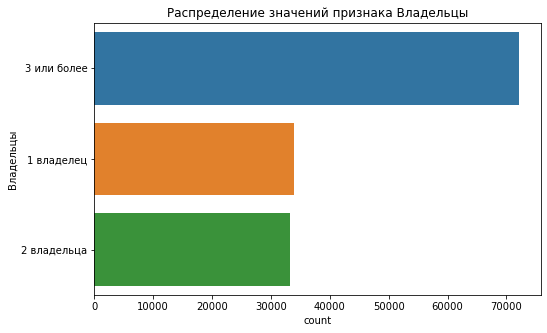

In [257]:
getCountPlot(data,'Владельцы')

### Привод

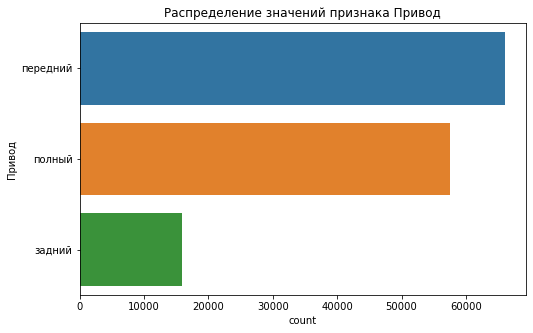

In [258]:
getCountPlot(data,'Привод')

### ПТС

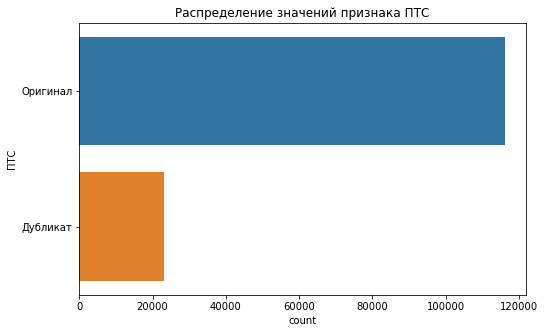

In [259]:
getCountPlot(data,'ПТС')

### Руль

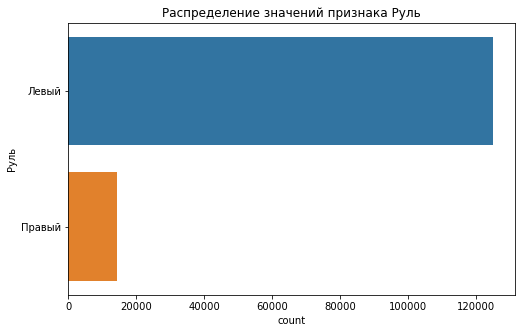

In [260]:
getCountPlot(data,'Руль')

### Состояние

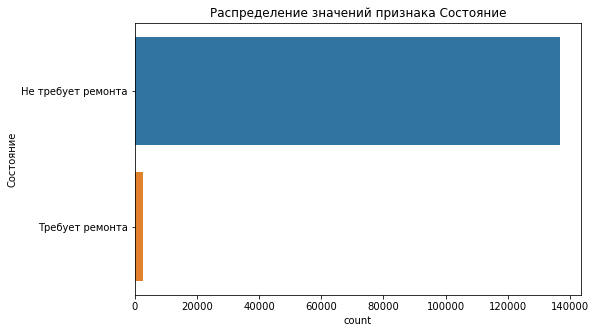

In [261]:
getCountPlot(data,'Состояние')

Крайне незначительное количество автомобилей, требующих ремонта

### mileage

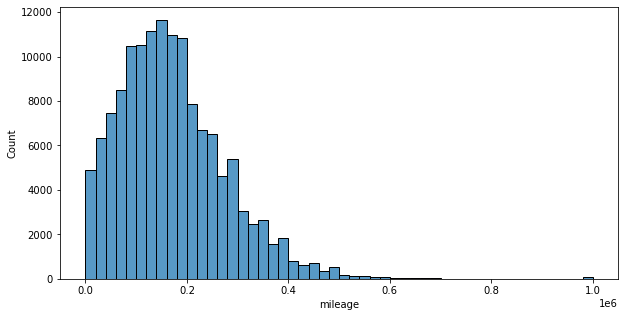

In [262]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['mileage'], bins=50);

Есть автомобили с пробегом под 1 млн. километров. Посмотрим на них

In [263]:
data[data['mileage']>999999].groupby(['brand', 'mileage','Состояние'])['sell_id'].count()

brand       mileage  Состояние         
AUDI        1000000  Не требует ремонта    3
BMW         1000000  Не требует ремонта    3
                     Требует ремонта       1
HONDA       1000000  Не требует ремонта    1
MERCEDES    1000000  Не требует ремонта    3
                     Требует ремонта       1
MITSUBISHI  1000000  Не требует ремонта    1
NISSAN      1000000  Не требует ремонта    1
                     Требует ремонта       1
TOYOTA      1000000  Не требует ремонта    6
                     Требует ремонта       2
VOLKSWAGEN  1000000  Не требует ремонта    5
                     Требует ремонта       1
VOLVO       1000000  Не требует ремонта    1
Name: sell_id, dtype: int64

Удивительно, конечно, что автомобиль с пробегом 1 млн килорметров "не требует ремонта", но проверка показала, что именно так и указано в объявлении, при том, что в описании часто перечислены значительные неисправности... 

И хотя пробег возможно и реальный, но лучше считать это выбросом и удалить. Таких значений не много.

Посмотрим на распределение признака внутри межквартильного размаха

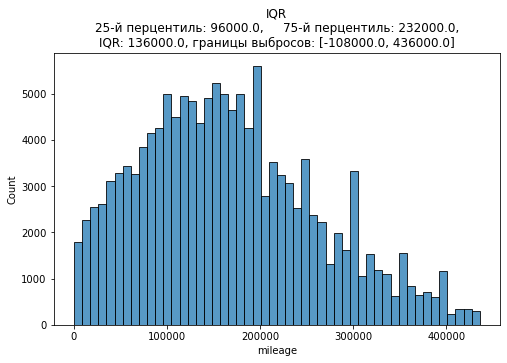

In [264]:
interquartile_range(data['mileage'], bins=50)

Распределение в целом нормальное.
Любопытны аномальные выбросы вблизи "круглых" значений пробега - 150, 200, 250, 300, 350, 400 тысяч километров.

Может свидетельствовать о наличии в этих группах определённой доли автомобилей с "нечестным" пробегом.

In [265]:
# заменим выбросы на медиану
emission_replacement(data,'mileage', method='median')

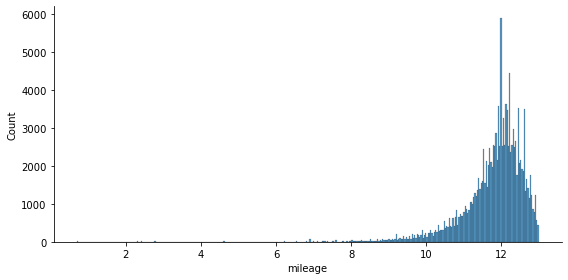

In [266]:
# логарифмируем
data['mileage'] = data['mileage'].apply(lambda w: np.log(w + 1))
sns.displot(data=data, x="mileage", height=4, aspect=2);

# Подготовка данных

In [267]:
# Категориальные признаки
cat_cols = ['bodyType','brand','color','fuelType','model_name','vehicleTransmission','vendor','Владельцы','Привод']
# бинарные
bin_cols = ['ПТС','Руль','Состояние']
# Количественные
nom_cols = ['enginePower','mileage','modelDate','numberOfDoors','productionDate','engineDisplacement','description_len']

## Стандартизация

In [268]:
# Для экспериментов
scaler = StandardScaler()
df_nom = pd.DataFrame(scaler.fit_transform(data[nom_cols]),columns=nom_cols)
df_nom.sample(2)

,enginePower,mileage,modelDate,numberOfDoors,productionDate,engineDisplacement,description_len
23845,1.85,0.94,-0.71,-0.72,-1.01,2.29,-0.38
118317,-0.43,0.39,0.04,0.78,-0.10,-0.33,0.78


## Нормализация

In [269]:
# scaler = MinMaxScaler()
# df_nom = pd.DataFrame(scaler.fit_transform(data[nom_cols]),columns=nom_cols)
# df_nom.sample(2)

## Label Encoding

In [270]:
# Кодируем категориальные признаки
df_cat = pd.DataFrame()
for colum in cat_cols:
    df_cat[colum] = data[colum].astype('category').cat.codes
df_cat.sample(2)

,bodyType,brand,color,fuelType,model_name,vehicleTransmission,vendor,Владельцы,Привод
82618,15,9,1,0,123,2,1,2,1
47724,15,11,11,0,405,3,0,2,1


In [271]:
# Кодируем бинарные признаки
le = LabelEncoder()
df_bin = pd.DataFrame()
for col in bin_cols:
    le.fit(data[col])
    df_bin[col] = le.transform(data[col])
    
df_bin.sample(2)

,ПТС,Руль,Состояние
132456,1,0,0
22172,1,0,0


In [272]:
# Соединяем
df = pd.concat([df_nom, df_cat, df_bin], sort=False,axis=1)
df[['price','sample']] = data[['price','sample']].copy()

df.sample(2)

,enginePower,mileage,modelDate,numberOfDoors,productionDate,engineDisplacement,description_len,bodyType,brand,color,...,model_name,vehicleTransmission,vendor,Владельцы,Привод,ПТС,Руль,Состояние,price,sample
7442,-0.94,-0.26,-0.21,-0.72,-0.23,-0.77,-2.83,15,6,15,...,259,0,1,1,1,1,0,0,370000.00,1
107096,2.05,0.33,0.29,0.78,0.16,2.07,0.95,1,0,11,...,366,0,0,1,2,1,0,0,nan,0


In [273]:
# # Создание полиномиальных признаков - не дало существенного прироста качества 
# lst = nom_cols + cat_cols
# pf = PolynomialFeatures(2)
# X_poly = pd.DataFrame(pf.fit_transform(df[lst]))
# df = pd.concat([df, X_poly], sort=False, axis=1)
# df.sample(2)

In [274]:
df.describe()

,enginePower,mileage,modelDate,numberOfDoors,productionDate,engineDisplacement,description_len,bodyType,brand,color,...,model_name,vehicleTransmission,vendor,Владельцы,Привод,ПТС,Руль,Состояние,price,sample
count,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,...,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,139330.00,104644.00,139330.00
mean,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,9.85,6.02,9.49,...,267.39,0.88,0.45,1.28,1.30,0.83,0.10,0.02,1207853.59,0.75
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,7.56,3.41,5.45,...,160.24,1.07,0.50,0.83,0.66,0.37,0.30,0.13,1351163.99,0.43
min,-1.75,-12.54,-12.85,-6.73,-13.61,-2.51,-4.32,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12000.00,0.00
25%,-0.72,-0.35,-0.58,-0.72,-0.62,-0.77,-0.60,1.00,3.00,4.00,...,121.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,395000.00,1.00
50%,-0.30,0.22,0.17,0.78,0.29,-0.33,0.09,15.00,7.00,12.00,...,271.00,0.00,0.00,2.00,1.00,1.00,0.00,0.00,799000.00,1.00
75%,0.45,0.61,0.79,0.78,0.68,0.54,0.77,15.00,9.00,15.00,...,382.00,2.00,1.00,2.00,2.00,1.00,0.00,0.00,1550000.00,1.00
max,5.48,1.36,1.67,0.78,1.45,4.69,1.64,23.00,11.00,15.00,...,543.00,3.00,1.00,2.00,2.00,1.00,1.00,1.00,30850000.00,1.00


## ИТОГИ ПРЕДОБРАБОТКИ

## Значение номинативных признаков

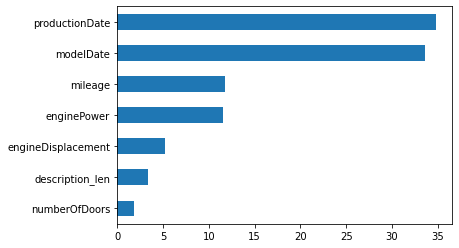

In [275]:
result = df[df['sample'] == 1].copy()
result = pd.Series(f_classif(result[nom_cols], result['price'])[0], index=[nom_cols][0])
result.sort_values(inplace=True)
result.plot(kind='barh');

Всё закономеро - цена сильно зависит от года и пробега

## Значение категориальных и бинарных признаков

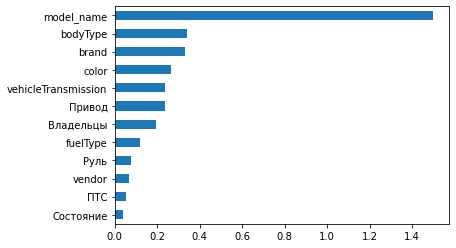

In [276]:
result = df[df['sample'] == 1].copy()
result = pd.Series(mutual_info_classif(result[cat_cols + bin_cols],result['price'],
    discrete_features=True), index=[cat_cols + bin_cols][0])
result.sort_values(inplace=True)
result.plot(kind='barh');

Построим общую корреляционную матрицу для всех обработанных признаков

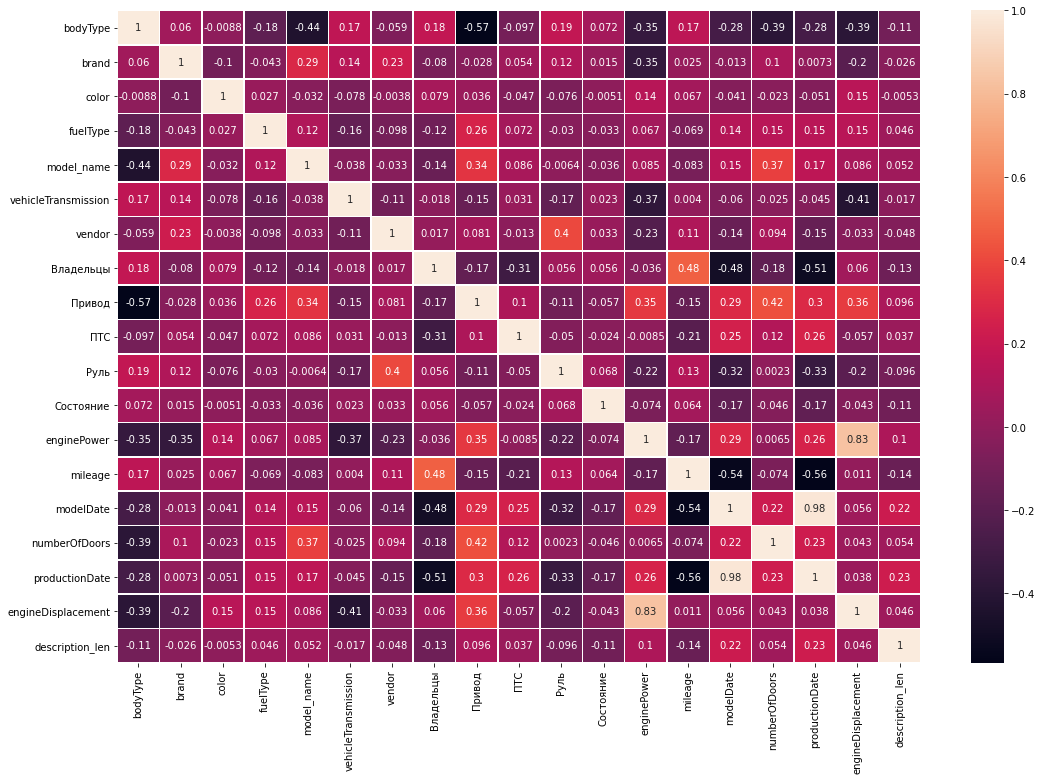

In [277]:
result = df[df['sample'] == 1].copy()
plt.figure(figsize=(18, 12))
sns.heatmap(result[cat_cols + bin_cols + nom_cols].corr(),annot=True, linewidths=.5);

Сильная корреляция между:

* modelDate - productionDate
* engineDisplacement - enginePower

Объединим признаки методом главных компонент

In [278]:
feature = {'periodOperation': ['modelDate', 'productionDate'],
           'engine': ['engineDisplacement', 'enginePower']}
for key in feature.keys():
    result = df[feature[key]].values

    # создаём экземпляр Scaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(result)

    # Указываем новую размерность - n_components
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    
    # создаём новый признак
    df[key] = pca_data
    df = df.drop(feature[key],axis=1)

# Скорректируем количественные признаки
nom_cols = ['engine','mileage','numberOfDoors','periodOperation','description_len']

Смотрим на результат:

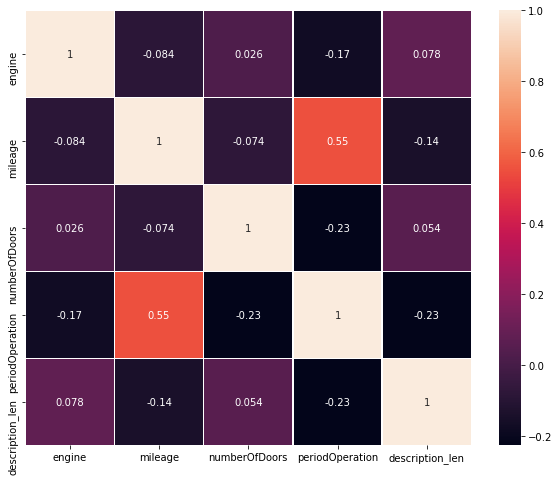

In [279]:
result = df[df['sample'] == 1].copy()
plt.figure(figsize=(10, 8))
sns.heatmap(result[nom_cols].corr(),annot=True, linewidths=.5);

Значительных корреляций нет

## Train Split

In [280]:
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
y = df.query('sample == 1')['price'] 
X_sub = df.query('sample == 0').drop(['sample', 'price'], axis=1)

display(f'y {y.shape}, train {X.shape}, test {X_sub.shape}')

'y (104644,), train (104644, 17), test (34686, 17)'

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Модели

In [282]:
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

## Lazypredict

Определим наиболее подходящую модель

In [283]:
# # # Для проверки моделей используем 10% данных
# start = datetime.now()
# offset = int(X.shape[0] * 0.9)

# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mape)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

```
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
XGBRegressor                                 0.91       0.91  595420.87   
LGBMRegressor                                0.89       0.89  652713.35   
ExtraTreesRegressor                          0.89       0.89  652832.40   
HistGradientBoostingRegressor                0.89       0.89  661996.65   
RandomForestRegressor                        0.88       0.88  694623.33   
BaggingRegressor                             0.88       0.88  706276.89   
ExtraTreeRegressor                           0.87       0.87  709650.79   
GradientBoostingRegressor                    0.86       0.86  755500.67   
DecisionTreeRegressor                        0.83       0.83  837041.05   
KNeighborsRegressor                          0.80       0.80  892743.07   
PoissonRegressor                             0.69       0.69 1110058.78   
MLPRegressor                                 0.57       0.57 1320252.33   
SGDRegressor                                 0.55       0.55 1345162.66   
LinearRegression                             0.54       0.54 1353922.44   
TransformedTargetRegressor                   0.54       0.54 1353922.44   
Lars                                         0.54       0.54 1353922.44   
Lasso                                        0.54       0.54 1353923.28   
Ridge                                        0.54       0.54 1353925.26   
RidgeCV                                      0.54       0.54 1353950.71   
LassoLarsIC                                  0.54       0.54 1353953.97   
BayesianRidge                                0.54       0.54 1353969.68   
LassoLars                                    0.54       0.54 1354190.36   
LassoLarsCV                                  0.54       0.54 1356595.90   
LarsCV                                       0.54       0.54 1356595.90   
LassoCV                                      0.54       0.54 1359422.11   
OrthogonalMatchingPursuitCV                  0.54       0.54 1365904.19   
ElasticNet                                   0.45       0.45 1480839.55   
GammaRegressor                               0.45       0.45 1482874.68   
HuberRegressor                               0.42       0.42 1527823.90   
PassiveAggressiveRegressor                   0.40       0.40 1550372.91   
RANSACRegressor                              0.40       0.40 1556466.78   
TweedieRegressor                             0.38       0.38 1573060.79   
GeneralizedLinearRegressor                   0.38       0.38 1573060.79   
OrthogonalMatchingPursuit                    0.21       0.22 1775880.52   
AdaBoostRegressor                            0.03       0.03 1974856.41   
ElasticNetCV                                -0.21      -0.21 2204529.43   
DummyRegressor                              -0.21      -0.21 2207947.67   
NuSVR                                       -0.34      -0.34 2319552.19   
SVR                                         -0.44      -0.43 2401142.85   
LinearSVR                                   -0.94      -0.93 2788813.23   

                               Time Taken  mape  
Model                                            
XGBRegressor                         7.22  0.11  
LGBMRegressor                        0.98  0.13  
ExtraTreesRegressor                 56.95  0.11  
HistGradientBoostingRegressor        3.08  0.13  
RandomForestRegressor               75.03  0.11  
BaggingRegressor                     8.00  0.11  
ExtraTreeRegressor                   0.70  0.15  
GradientBoostingRegressor           19.16  0.16  
DecisionTreeRegressor                1.33  0.15  
KNeighborsRegressor                 16.36  0.19  
PoissonRegressor                     0.55  0.26  
MLPRegressor                       268.04  0.43  
SGDRegressor                         0.64  0.40  
LinearRegression                     0.23  0.39  
TransformedTargetRegressor           0.22  0.39  
Lars                                 0.21  0.39  
Lasso                                0.32  0.39  
Ridge                                0.21  0.39  
RidgeCV                              0.38  0.39  
LassoLarsIC                          0.25  0.39  
BayesianRidge                        0.27  0.39  
LassoLars                            0.21  0.39  
LassoLarsCV                          1.00  0.39  
LarsCV                               0.97  0.39  
LassoCV                              1.19  0.39  
OrthogonalMatchingPursuitCV          0.65  0.39  
ElasticNet                           0.24  0.39  
GammaRegressor                       0.36  0.35  
HuberRegressor                       0.91  0.34  
PassiveAggressiveRegressor           2.76  0.34  
RANSACRegressor                      0.83  0.36  
TweedieRegressor                     0.26  0.41  
GeneralizedLinearRegressor           0.31  0.41  
OrthogonalMatchingPursuit            0.18  0.56  
AdaBoostRegressor                   11.24  1.84  
ElasticNetCV                         1.09  0.69  
DummyRegressor                       0.15  0.69  
NuSVR                             1098.75  0.62  
SVR                               1887.86  0.61  
LinearSVR                            0.31  0.90 
```

## Lazypredict - модели с лучшей метрикой MAPE

Model|Time Taken | mape
:-|-:|-:                                      
XGBRegressor|                         7.22|  0.11   
ExtraTreesRegressor|                 56.95 | 0.11   
RandomForestRegressor         |      75.03 | 0.11  
BaggingRegressor               |      8.00 | 0.11 



Самые быстрые XGBRegressor и BaggingRegressor

Но проверим еще некоторые модели

##  CatBoost

In [284]:
# start = datetime.now()

model = CatBoostRegressor(iterations = 5000,
                          cat_features=cat_cols,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         use_best_model=True,
         verbose=False,
         plot=True
         )

model.save_model('catboost_model.model')

predict = model.predict(X_test)
print_learn_report(start, y_test, predict)

CatBoost

1. iterations = 50
   * Время выполнения -  0:00:09.447007
   * Точность по метрике MAPE:24.08%
   
   
2. iterations = 500
   * Время выполнения -  0:02:03.490157
   * Точность по метрике MAPE:19.13%
   
3. iterations = 5000
   * Время выполнения -  0:23:52.186108
   * Точность по метрике MAPE:17.65%

## Log Traget

Логарифмирование целевой переменной и подбор наилучших параметров

Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [ ]:
start = datetime.now()



# model = CatBoostRegressor(cat_features=cat_cols, iterations=50
#                           ,loss_function='MAPE', metric_period=10)

# grid = {'learning_rate': [ 0.13, 0.14, 0.15]
#         ,'depth': [12]
#         ,'l2_leaf_reg': [7, 7.5, 8]
#         ,'random_strength': [0.3]}

# grid_search_result = model.grid_search(grid
#                                     ,X=X_train
#                                     ,y=np.log(y_train)
#                                     ,plot=True
#                                     ,verbose=False)
# print('\nВремя выполнения - ', datetime.now() - start)
# print('\nНаилучшие параметры: ', grid_search_result['params'])


# Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 7.5, 'random_strength': 0.3, 'learning_rate': 0.15}
# Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 8, 'random_strength': 0.3, 'learning_rate': 0.15}

cb = CatBoostRegressor(iterations = 5000,
                       random_seed = RANDOM_SEED,
                       eval_metric='MAPE',
                       custom_metric=['R2', 'MAE'],
                       silent=True,
                       learning_rate=0.15, depth=12,
                       l2_leaf_reg=7.5, random_strength=0.3)

cb.fit(X_train, np.log(y_train),
        eval_set=(X_test, np.log(y_test)),
        verbose=False,
        use_best_model=True,
        plot=True)

cb.save_model('catboost_log_model.model')

predict_test = np.exp(cb.predict(X_test))
print_learn_report(start, y_test, predict_test)

## Random Forest

In [286]:
start = datetime.now()

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator = rfr, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=10, 
#                                random_state=RANDOM_SEED, n_jobs = -1)
# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# best_params_: 
# {'n_estimators': 300,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': False}

# best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED,
                                 n_estimators=300,
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=None,
                                 bootstrap=False)

best_rfr.fit(X_train, np.log(y_train))


predict_rfr = np.exp(best_rfr.predict(X_test))
print_learn_report(start, y_test, predict_rfr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 51


Время выполнения -  1:24:33.145903
Точность по метрике MAPE:14.87%


До балансировки train:
* Время выполнения -  0:01:13.717099
* Точность по метрике MAPE:15.45%

После балансировки:
* Время выполнения -  0:01:10.617567
* Точность по метрике MAPE:14.87%

## Gradient Boosting Regressor

In [287]:
start = datetime.now()

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4]}

# gbr = GradientBoostingRegressor()
# gbr_random = RandomizedSearchCV(estimator = gbr, 
#                                 param_distributions = random_grid, 
#                                 n_iter = 100, 
#                                 cv = 3, 
#                                 verbose=10, 
#                                 random_state=RANDOM_SEED,
#                                 n_jobs = -1)

# gbr_random.fit(X_train, np.log(y_train))
# gbr_random.best_params_

best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                     n_estimators=400,
                                     min_samples_split=2,
                                     min_samples_leaf=4,
                                     max_features='auto',
                                     max_depth=7)

best_gbr.fit(X_train, np.log(y_train))

predict_gbr = np.exp(best_gbr.predict(X_test))
print_learn_report(start, y_test, predict_gbr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 57


Время выполнения -  1:37:42.045033
Точность по метрике MAPE:14.75%


До балансировки train:
* Время выполнения -  0:02:32.952335
* Точность по метрике MAPE:15.52%

После балансировки:
* Время выполнения -  0:02:24.388945
* Точность по метрике MAPE:14.75%

## XGB Regressor

In [288]:
start = datetime.now()

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb_reg.fit(X_train, np.log(y_train))
xgb_red_pred = np.exp(xgb_reg.predict(X_test))
print_learn_report(start, y_test, xgb_red_pred)


Время выполнения -  0:01:28.856844
Точность по метрике MAPE:14.38%


До балансировки train:
* Время выполнения -  0:01:19.694085
* Точность по метрике MAPE:15.17%

После балансировки:
* Время выполнения -  0:01:26.097734
* Точность по метрике MAPE:14.41%

## BaggingRegressor

###  + Random Forest

In [289]:
start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)


Время выполнения -  0:02:17.662062
Точность по метрике MAPE:15.10%


До балансировки train:
* Время выполнения -  0:02:28.042826
* Точность по метрике MAPE:15.67%

После балансировки:
* Время выполнения -  0:02:18.727628
* Точность по метрике MAPE:15.14%

###  + Gradient Boosting Regressor

In [290]:
start = datetime.now()

bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_gbr)


Время выполнения -  0:04:36.315738
Точность по метрике MAPE:14.68%


До балансировки train:
* Время выполнения -  0:04:51.523686
* Точность по метрике MAPE:15.40%

После балансировки:
* Время выполнения -  0:04:42.424589
* Точность по метрике MAPE:14.70%

### + XGB Regressor

In [291]:
start = datetime.now()

bagg_xgb = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print_learn_report(start, y_test, predict_bagg_xgb)


Время выполнения -  0:04:34.312408
Точность по метрике MAPE:14.43%


До балансировки train:
* Время выполнения -  0:04:21.817135
* Точность по метрике MAPE:15.15%

После балансировки:

* Время выполнения -  0:04:57.274643
* Точность по метрике MAPE:14.42%

#### BaggingRegressor + (результаты в порядке убывания качества):

1. XGB Regressor: : результат улучшен (лучший из всех)
2. Gradient Boosting Regressor: результат улучшен
3. Random Forest: результат ухудшился

# Стекинг

In [292]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    return X_meta_train, X_meta_test

In [293]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    
    features = [compute_meta_feature(clf,X_train,X_test,y_train,
                                     cv) for clf in tqdm(classifiers)]

    stacked_features_train = np.vstack(
        [features_train for features_train, features_test in features]).T

    stacked_features_test = np.vstack(
        [features_test for features_train, features_test in features]).T

    return stacked_features_train, stacked_features_test

In [294]:
start = datetime.now()

# параметры кросс-валидации
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# # # список_1 базовых моделей для стекинга (параметры по умолчанию)
# list_clf = [xgb.XGBRegressor(objective='reg:squarederror'),
#             GradientBoostingRegressor(random_state=RANDOM_SEED),
#             RandomForestRegressor(random_state=RANDOM_SEED),
#             ExtraTreesRegressor(random_state=RANDOM_SEED)]


# список_2 базовых моделей для стекинга (параметры подобраны)
list_clf = [xgb.XGBRegressor(objective='reg:squarederror',
                             colsample_bytree=0.5,
                             learning_rate=0.05,
                             max_depth=12,
                             alpha=1,
                             n_estimators=1000),
            GradientBoostingRegressor(random_state=RANDOM_SEED,
                                      n_estimators=400,
                                      min_samples_split=2,
                                      min_samples_leaf=4,
                                      max_features='auto',
                                      max_depth=7),
            RandomForestRegressor(random_state=RANDOM_SEED,
                                  n_estimators=300,
                                  min_samples_split=10,
                                  min_samples_leaf=1,
                                  max_features='sqrt',
                                  max_depth=None,
                                  bootstrap=False),
            ExtraTreesRegressor(random_state=RANDOM_SEED)]


# генерируем новые признаки
stacked_features_train, stacked_features_test = generate_meta_features(list_clf,
                                                                       X_train.values,
                                                                       X_test.values,
                                                                       y_train.values,
                                                                       cv)
# объединяем имеющиеся и созданные стекингом признаки
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

# обучаем мета-модель на объединённых признаках
stacked_xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
stacked_xgb_reg.fit(total_features_train, np.log(y_train))
stacked_xgb_reg_pred = np.exp(stacked_xgb_reg.predict(total_features_test))
print_learn_report(start, y_test, stacked_xgb_reg_pred)

100%|██████████| 4/4 [17:31<00:00, 262.84s/it]



Время выполнения -  0:17:40.660694
Точность по метрике MAPE:14.61%


До балансировки train:
* Время выполнения -  0:18:28.895312
* Точность по метрике MAPE:15.26%

После балансировки:
* Время выполнения -  0:17:47.417858
* Точность по метрике MAPE:14.65%



* Стекинг с настроенными базовыми моделями и с моделями по умолчанию не показал существенных отличий
* Метрика хуже чем BaggingRegressor +XGB - возможно не правильно настроен.

Для окончательного применения выбрана BaggingRegressor + XGB, как самая быстрая и точная в метрике MAPE

# Submission

In [300]:
k = 0.8575
# # VERSION= '_bagg_xgb'
# predict_submission = np.exp(bagg_xgb.predict(X_sub))


VERSION= '_xgb_reg'
predict_submission = np.exp(xgb_reg.predict(X_sub))

In [301]:
predict_submission.shape

(34686,)

In [302]:
# Экспериментальным путём подобран коэффициент, при котором результат максимальный
sample_submission['price'] = predict_submission * k
sample_submission.to_csv(f'submission_v{VERSION}_{k}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,638909.19
1,1100549428,1069562.50
2,1100658222,899136.00
3,1100937408,812751.12
4,1101037972,727999.44
5,1100912634,724974.56
6,1101228730,663164.69
7,1100165896,419055.62
8,1100768262,1855510.00
9,1101218501,861597.19


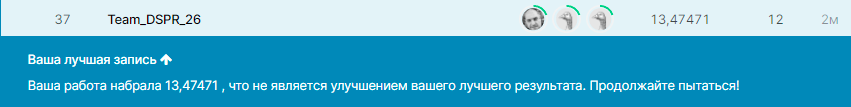

Можно было бы еще улучшить результат:
* наверняка результат улучшился бы если сбалансировать значения признаков в train и test (чтобы в используемых признаках обоих датасетов были бы только совпадающие значения - одинаковые названия марок, типы двигателей и т.д.)